In [ ]:
!pip install -U transformers==4.46.2 accelerate==1.2.1 datasets evaluate seqeval sentencepiece

In [ ]:
!pip uninstall -y peft

Found existing installation: peft 0.18.0
Uninstalling peft-0.18.0:
  Successfully uninstalled peft-0.18.0


In [ ]:
# CELL 0 — RUN ONCE
# Preprocessing + tokenizer + shared functions + splits

import pandas as pd
import numpy as np
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer
)
import evaluate
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# -------------- CONFIG --------------
MODEL_NAME = "roberta-base"
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 3e-5
WEIGHT_DECAY = 0.01
GRADIENT_ACCUMULATION = 2
WARMUP_STEPS = 500
FP16 = True  # use mixed precision if available

# -------------- LOAD CSV --------------
# Update path if needed
df = pd.read_csv("/content/TV_Reviews(Sheet1).csv")
assert {"sentence_id", "word", "tag"}.issubset(df.columns), "CSV must have sentence_id, word, tag"

# -------------- GROUP SENTENCES --------------
sentences = []
tags = []
for _, g in df.groupby("sentence_id"):
    sentences.append(g["word"].tolist())
    tags.append(g["tag"].tolist())

print(f"Total sentences: {len(sentences)}")

# -------------- LABELS --------------
# You said 3 classes — build label list from data to map
label_list = sorted(list({t for seq in tags for t in seq}))
if len(label_list) != 3:
    print("Warning: found", len(label_list), "unique labels in data. Expected 3.")
label2id = {l: i for i, l in enumerate(label_list)}
id2label = {i: l for l, i in label2id.items()}
num_labels = len(label_list)
print("Labels:", label_list)

# Convert tags -> ids
label_ids = [[label2id[t] for t in seq] for seq in tags]

# -------------- HF Dataset --------------
hf_ds = Dataset.from_dict({"tokens": sentences, "labels": label_ids})

# -------------- TOKENIZER --------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True, add_prefix_space=True)

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        is_split_into_words=True,
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
    )
    aligned_labels = []
    for i, lab in enumerate(examples["labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        prev_word_idx = None
        label_ids_per_token = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids_per_token.append(-100)
            elif word_idx != prev_word_idx:
                # first token of the word
                label_ids_per_token.append(lab[word_idx])
            else:
                # continuation token
                label_ids_per_token.append(-100)
            prev_word_idx = word_idx
        aligned_labels.append(label_ids_per_token)
    tokenized_inputs["labels"] = aligned_labels
    return tokenized_inputs

# -------------- METRICS helpers --------------
seqeval = evaluate.load("seqeval")

def compute_metrics(p):
    preds, labels = p
    preds = np.argmax(preds, axis=2)

    true_preds = [
        [label_list[p] for (p, l) in zip(pred_seq, lab_seq) if l != -100]
        for pred_seq, lab_seq in zip(preds, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(pred_seq, lab_seq) if l != -100]
        for pred_seq, lab_seq in zip(preds, labels)
    ]

    results = seqeval.compute(predictions=true_preds, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

# -------------- K-Fold splits (random) --------------
kf = KFold(n_splits=6, shuffle=True, random_state=None)
splits = list(kf.split(hf_ds))   # store splits so all cells use same fold indices within this session
print("Prepared 6 random folds (shuffle=True).")


Map:   0%|          | 0/10036 [00:00<?, ? examples/s]

Map:   0%|          | 0/2008 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipython-input-258494361.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🚀 Training Fold 1 (epochs=5) ...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.708200,0.547809,0.256848,0.275132,0.265676,0.772457
2,0.536000,0.482429,0.354998,0.346801,0.350852,0.804648
3,0.460100,0.441968,0.362840,0.358826,0.360822,0.819771
4,0.401000,0.454581,0.383349,0.392015,0.387634,0.818629
5,0.357800,0.459490,0.391572,0.397787,0.394655,0.825829


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



📊 Trainer Evaluate (Fold 1)



--- TRAIN METRICS (from trainer.evaluate) ---
{'eval_loss': 0.30207762122154236, 'eval_precision': 0.48961738127283216, 'eval_recall': 0.48657686060953476, 'eval_f1': 0.4880923858354497, 'eval_accuracy': 0.8790689132730362, 'eval_runtime': 21.9632, 'eval_samples_per_second': 456.945, 'eval_steps_per_second': 28.593, 'epoch': 5.0}

--- TEST METRICS (from trainer.evaluate) ---
{'eval_loss': 0.4594901204109192, 'eval_precision': 0.3915719696969697, 'eval_recall': 0.3977873977873978, 'eval_f1': 0.3946552135528513, 'eval_accuracy': 0.8258285714285715, 'eval_runtime': 4.4472, 'eval_samples_per_second': 451.517, 'eval_steps_per_second': 28.332, 'epoch': 5.0}

Train classification report:
              precision    recall  f1-score   support

         BOC       0.70      0.63      0.66      8847
         IOC       0.81      0.80      0.80     32010
           O       0.92      0.93      0.93     89829

    accuracy                           0.88    130686
   macro avg       0.81      0.79    

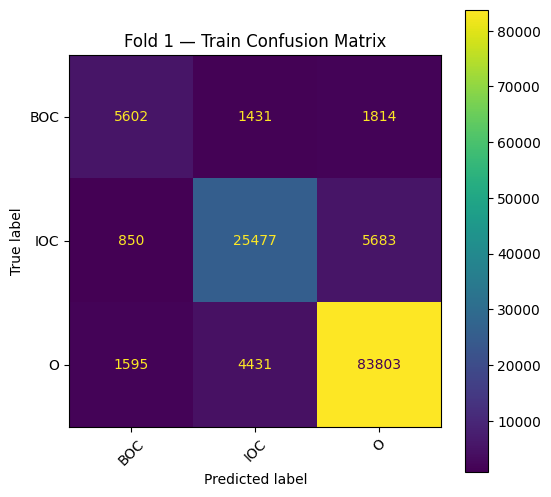

/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



Test classification report:
              precision    recall  f1-score   support

         BOC       0.61      0.54      0.57      1759
         IOC       0.71      0.70      0.71      6280
           O       0.88      0.89      0.89     18211

    accuracy                           0.83     26250
   macro avg       0.73      0.71      0.72     26250
weighted avg       0.82      0.83      0.82     26250



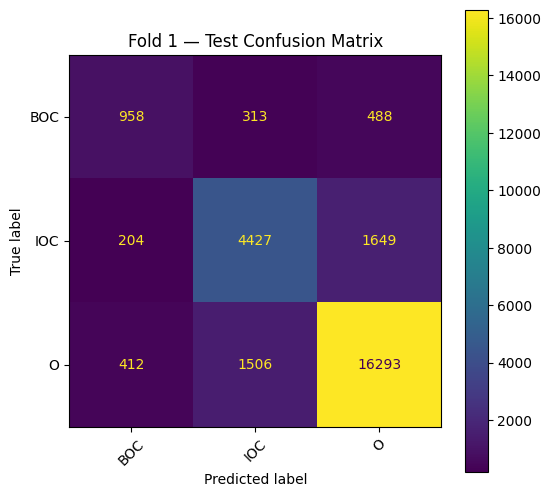

In [ ]:
# CELL 1 — FOLD 1
fold_idx = 1
train_idx, test_idx = splits[0]

train_data = hf_ds.select(train_idx)
test_data  = hf_ds.select(test_idx)

tokenized_train = train_data.map(tokenize_and_align_labels, batched=True, remove_columns=train_data.column_names)
tokenized_test  = test_data.map(tokenize_and_align_labels, batched=True, remove_columns=test_data.column_names)

# create model and move to GPU
model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_args = TrainingArguments(
    output_dir=f"./fold{fold_idx}",
    evaluation_strategy="epoch",
    save_strategy="no",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION,
    learning_rate=LEARNING_RATE,
    num_train_epochs=EPOCHS,
    weight_decay=WEIGHT_DECAY,
    warmup_steps=WARMUP_STEPS,
    fp16=FP16 and torch.cuda.is_available(),
    logging_strategy="epoch",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics
)

print(f"🚀 Training Fold {fold_idx} (epochs={EPOCHS}) ...")
trainer.train()

# Evaluate (trainer.evaluate uses compute_metrics)
print(f"\n📊 Trainer Evaluate (Fold {fold_idx})")
eval_metrics = trainer.evaluate(eval_dataset=tokenized_test)
train_metrics = trainer.evaluate(eval_dataset=tokenized_train)

print("\n--- TRAIN METRICS (from trainer.evaluate) ---")
print(train_metrics)
print("\n--- TEST METRICS (from trainer.evaluate) ---")
print(eval_metrics)

# ---------------- Predictions & Confusion Matrices ----------------
def preds_and_labels(tok_dataset):
    preds_output = trainer.predict(tok_dataset)
    preds = np.argmax(preds_output.predictions, axis=2)
    labels = preds_output.label_ids

    y_true = []
    y_pred = []
    for pred_seq, label_seq in zip(preds, labels):
        for p, l in zip(pred_seq, label_seq):
            if l != -100:
                y_true.append(id2label[int(l)])
                y_pred.append(id2label[int(p)])
    return y_true, y_pred

# Train confusion matrix
y_true_train, y_pred_train = preds_and_labels(tokenized_train)
cm_labels = label_list  # sorted label strings
cm_train = confusion_matrix(y_true_train, y_pred_train, labels=cm_labels, normalize=None)
print("\nTrain classification report:")
print(classification_report(y_true_train, y_pred_train, labels=cm_labels, zero_division=0))
fig = plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Train Confusion Matrix")
plt.show()

# Test confusion matrix
y_true_test, y_pred_test = preds_and_labels(tokenized_test)
cm_test = confusion_matrix(y_true_test, y_pred_test, labels=cm_labels, normalize=None)
print("\nTest classification report:")
print(classification_report(y_true_test, y_pred_test, labels=cm_labels, zero_division=0))
fig = plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Test Confusion Matrix")
plt.show()


Map:   0%|          | 0/10036 [00:00<?, ? examples/s]

Map:   0%|          | 0/2008 [00:00<?, ? examples/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipython-input-3962749016.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🚀 Training Fold 2 (epochs=5) ...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.682000,0.541445,0.270118,0.271780,0.270946,0.780565
2,0.530100,0.501167,0.358986,0.375473,0.367045,0.798512
3,0.450400,0.466620,0.367320,0.390625,0.378614,0.810439
4,0.395200,0.469633,0.374773,0.391098,0.382762,0.813315
5,0.351100,0.476745,0.393044,0.390625,0.391831,0.818454


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



📊 Trainer Evaluate (Fold 2)



--- TRAIN METRICS (from trainer.evaluate) ---
{'eval_loss': 0.2959466576576233, 'eval_precision': 0.4965404574284067, 'eval_recall': 0.49520797393137816, 'eval_f1': 0.49587332053742805, 'eval_accuracy': 0.881491670487544, 'eval_runtime': 22.9943, 'eval_samples_per_second': 436.457, 'eval_steps_per_second': 27.311, 'epoch': 5.0}

--- TEST METRICS (from trainer.evaluate) ---
{'eval_loss': 0.476744681596756, 'eval_precision': 0.393044306812768, 'eval_recall': 0.390625, 'eval_f1': 0.39183091902161005, 'eval_accuracy': 0.8184537505752416, 'eval_runtime': 4.3715, 'eval_samples_per_second': 459.343, 'eval_steps_per_second': 28.823, 'epoch': 5.0}

Train classification report:
              precision    recall  f1-score   support

         BOC       0.71      0.65      0.68      8816
         IOC       0.82      0.79      0.80     31787
           O       0.92      0.94      0.93     90257

    accuracy                           0.88    130860
   macro avg       0.82      0.79      0.80    130

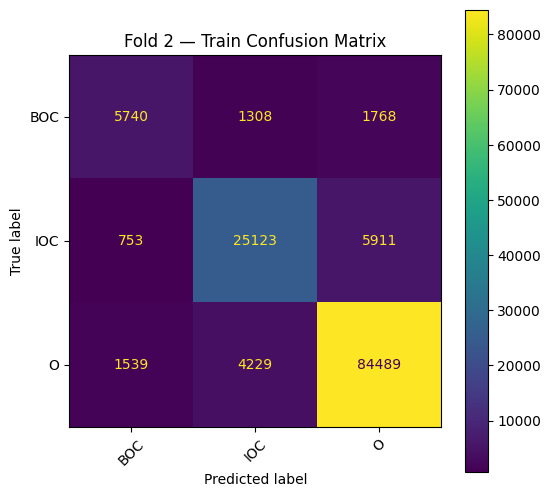

/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



Test classification report:
              precision    recall  f1-score   support

         BOC       0.61      0.53      0.57      1790
         IOC       0.72      0.67      0.70      6503
           O       0.87      0.90      0.88     17783

    accuracy                           0.82     26076
   macro avg       0.73      0.70      0.72     26076
weighted avg       0.81      0.82      0.82     26076



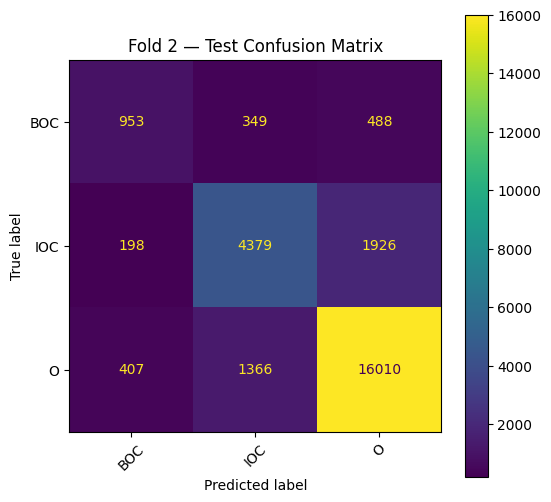

In [ ]:
# CELL 2 — FOLD 2
fold_idx = 2
train_idx, test_idx = splits[1]

train_data = hf_ds.select(train_idx)
test_data  = hf_ds.select(test_idx)

tokenized_train = train_data.map(tokenize_and_align_labels, batched=True, remove_columns=train_data.column_names)
tokenized_test  = test_data.map(tokenize_and_align_labels, batched=True, remove_columns=test_data.column_names)

model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_args = TrainingArguments(
    output_dir=f"./fold{fold_idx}",
    evaluation_strategy="epoch",
    save_strategy="no",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION,
    learning_rate=LEARNING_RATE,
    num_train_epochs=EPOCHS,
    weight_decay=WEIGHT_DECAY,
    warmup_steps=WARMUP_STEPS,
    fp16=FP16 and torch.cuda.is_available(),
    logging_strategy="epoch",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics
)

print(f"🚀 Training Fold {fold_idx} (epochs={EPOCHS}) ...")
trainer.train()

print(f"\n📊 Trainer Evaluate (Fold {fold_idx})")
eval_metrics = trainer.evaluate(eval_dataset=tokenized_test)
train_metrics = trainer.evaluate(eval_dataset=tokenized_train)

print("\n--- TRAIN METRICS (from trainer.evaluate) ---")
print(train_metrics)
print("\n--- TEST METRICS (from trainer.evaluate) ---")
print(eval_metrics)

# Confusion matrices
def preds_and_labels(tok_dataset):
    preds_output = trainer.predict(tok_dataset)
    preds = np.argmax(preds_output.predictions, axis=2)
    labels = preds_output.label_ids

    y_true = []
    y_pred = []
    for pred_seq, label_seq in zip(preds, labels):
        for p, l in zip(pred_seq, label_seq):
            if l != -100:
                y_true.append(id2label[int(l)])
                y_pred.append(id2label[int(p)])
    return y_true, y_pred

y_true_train, y_pred_train = preds_and_labels(tokenized_train)
cm_labels = label_list
print("\nTrain classification report:")
print(classification_report(y_true_train, y_pred_train, labels=cm_labels, zero_division=0))
fig = plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true_train, y_pred_train, labels=cm_labels), display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Train Confusion Matrix")
plt.show()

y_true_test, y_pred_test = preds_and_labels(tokenized_test)
print("\nTest classification report:")
print(classification_report(y_true_test, y_pred_test, labels=cm_labels, zero_division=0))
fig = plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true_test, y_pred_test, labels=cm_labels), display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Test Confusion Matrix")
plt.show()


Map:   0%|          | 0/10037 [00:00<?, ? examples/s]

Map:   0%|          | 0/2007 [00:00<?, ? examples/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipython-input-4291839201.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🚀 Training Fold 3 (epochs=5) ...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.679900,0.557964,0.265088,0.268579,0.266822,0.770105
2,0.535100,0.489514,0.338014,0.317027,0.327184,0.803087
3,0.454900,0.451653,0.367119,0.356068,0.361509,0.815955
4,0.401200,0.450797,0.374943,0.384290,0.379559,0.818861
5,0.357300,0.468552,0.377164,0.379116,0.378137,0.818597


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



📊 Trainer Evaluate (Fold 3)



--- TRAIN METRICS (from trainer.evaluate) ---
{'eval_loss': 0.30108028650283813, 'eval_precision': 0.4864174159962139, 'eval_recall': 0.49318618042226486, 'eval_f1': 0.48977841315225157, 'eval_accuracy': 0.8786080636629178, 'eval_runtime': 22.4259, 'eval_samples_per_second': 447.563, 'eval_steps_per_second': 28.003, 'epoch': 5.0}

--- TEST METRICS (from trainer.evaluate) ---
{'eval_loss': 0.46855196356773376, 'eval_precision': 0.37716424894712214, 'eval_recall': 0.3791157102539981, 'eval_f1': 0.37813746188130426, 'eval_accuracy': 0.8185969281859693, 'eval_runtime': 4.256, 'eval_samples_per_second': 471.568, 'eval_steps_per_second': 29.605, 'epoch': 5.0}

Train classification report:
              precision    recall  f1-score   support

         BOC       0.70      0.65      0.67      8837
         IOC       0.81      0.79      0.80     31782
           O       0.92      0.93      0.92     89818

    accuracy                           0.88    130437
   macro avg       0.81      0.79  

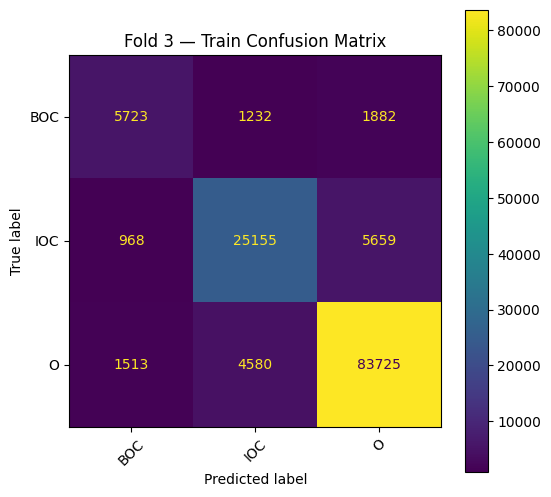

/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



Test classification report:
              precision    recall  f1-score   support

         BOC       0.59      0.53      0.56      1769
         IOC       0.71      0.68      0.70      6508
           O       0.87      0.90      0.88     18222

    accuracy                           0.82     26499
   macro avg       0.73      0.70      0.71     26499
weighted avg       0.81      0.82      0.82     26499



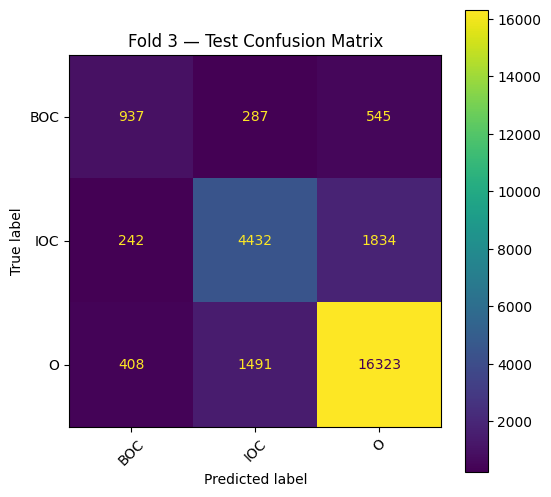

In [ ]:
# CELL 3 — FOLD 3
fold_idx = 3
train_idx, test_idx = splits[2]

train_data = hf_ds.select(train_idx)
test_data  = hf_ds.select(test_idx)

tokenized_train = train_data.map(tokenize_and_align_labels, batched=True, remove_columns=train_data.column_names)
tokenized_test  = test_data.map(tokenize_and_align_labels, batched=True, remove_columns=test_data.column_names)

model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_args = TrainingArguments(
    output_dir=f"./fold{fold_idx}",
    evaluation_strategy="epoch",
    save_strategy="no",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION,
    learning_rate=LEARNING_RATE,
    num_train_epochs=EPOCHS,
    weight_decay=WEIGHT_DECAY,
    warmup_steps=WARMUP_STEPS,
    fp16=FP16 and torch.cuda.is_available(),
    logging_strategy="epoch",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics
)

print(f"🚀 Training Fold {fold_idx} (epochs={EPOCHS}) ...")
trainer.train()

print(f"\n📊 Trainer Evaluate (Fold {fold_idx})")
eval_metrics = trainer.evaluate(eval_dataset=tokenized_test)
train_metrics = trainer.evaluate(eval_dataset=tokenized_train)

print("\n--- TRAIN METRICS (from trainer.evaluate) ---")
print(train_metrics)
print("\n--- TEST METRICS (from trainer.evaluate) ---")
print(eval_metrics)

# Confusion matrices same as above
def preds_and_labels(tok_dataset):
    preds_output = trainer.predict(tok_dataset)
    preds = np.argmax(preds_output.predictions, axis=2)
    labels = preds_output.label_ids

    y_true = []
    y_pred = []
    for pred_seq, label_seq in zip(preds, labels):
        for p, l in zip(pred_seq, label_seq):
            if l != -100:
                y_true.append(id2label[int(l)])
                y_pred.append(id2label[int(p)])
    return y_true, y_pred

y_true_train, y_pred_train = preds_and_labels(tokenized_train)
cm_labels = label_list
print("\nTrain classification report:")
print(classification_report(y_true_train, y_pred_train, labels=cm_labels, zero_division=0))
fig = plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true_train, y_pred_train, labels=cm_labels), display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Train Confusion Matrix")
plt.show()

y_true_test, y_pred_test = preds_and_labels(tokenized_test)
print("\nTest classification report:")
print(classification_report(y_true_test, y_pred_test, labels=cm_labels, zero_division=0))
fig = plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true_test, y_pred_test, labels=cm_labels), display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Test Confusion Matrix")
plt.show()


Map:   0%|          | 0/10037 [00:00<?, ? examples/s]

Map:   0%|          | 0/2007 [00:00<?, ? examples/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipython-input-2070851630.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🚀 Training Fold 4 (epochs=5) ...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.684900,0.532443,0.251325,0.276348,0.263243,0.780921
2,0.531600,0.466112,0.342093,0.347742,0.344894,0.811567
3,0.453600,0.455263,0.352157,0.384653,0.367688,0.816048
4,0.396500,0.450872,0.372082,0.394852,0.383129,0.819238
5,0.352500,0.463980,0.384435,0.398252,0.391221,0.822352


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



📊 Trainer Evaluate (Fold 4)



--- TRAIN METRICS (from trainer.evaluate) ---
{'eval_loss': 0.29560086131095886, 'eval_precision': 0.49496319256102284, 'eval_recall': 0.48726995327548395, 'eval_f1': 0.4910864446686848, 'eval_accuracy': 0.8813503518295904, 'eval_runtime': 22.1207, 'eval_samples_per_second': 453.738, 'eval_steps_per_second': 28.39, 'epoch': 5.0}

--- TEST METRICS (from trainer.evaluate) ---
{'eval_loss': 0.4639796018600464, 'eval_precision': 0.38443506797937177, 'eval_recall': 0.39825157843613407, 'eval_f1': 0.39122137404580154, 'eval_accuracy': 0.8223521816731857, 'eval_runtime': 4.1861, 'eval_samples_per_second': 479.446, 'eval_steps_per_second': 30.1, 'epoch': 5.0}

Train classification report:
              precision    recall  f1-score   support

         BOC       0.71      0.65      0.68      8842
         IOC       0.82      0.79      0.81     31930
           O       0.92      0.94      0.93     89831

    accuracy                           0.88    130603
   macro avg       0.82      0.79    

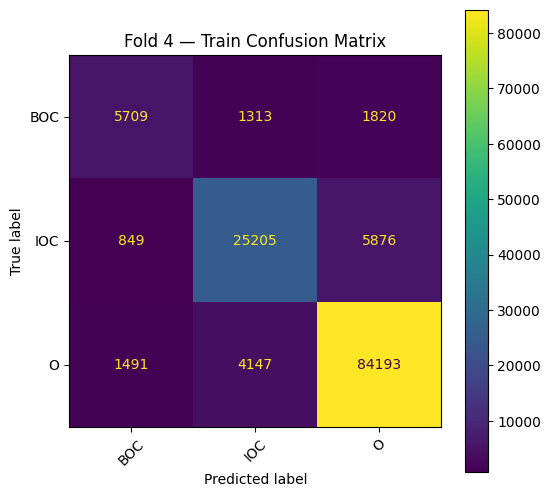

/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



Test classification report:
              precision    recall  f1-score   support

         BOC       0.61      0.55      0.58      1764
         IOC       0.71      0.69      0.70      6360
           O       0.88      0.90      0.89     18209

    accuracy                           0.82     26333
   macro avg       0.73      0.71      0.72     26333
weighted avg       0.82      0.82      0.82     26333



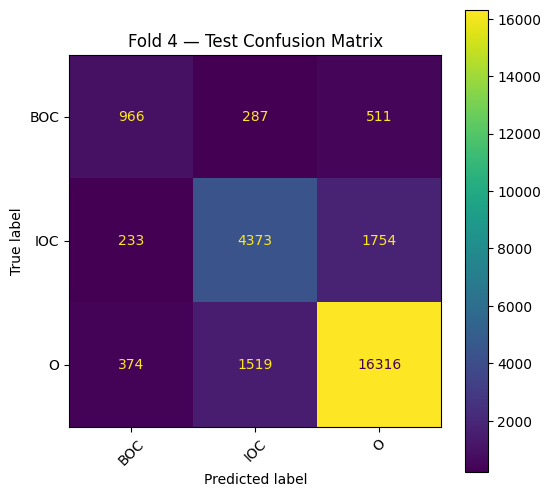

In [ ]:
# CELL 4 — FOLD 4
fold_idx = 4
train_idx, test_idx = splits[3]

train_data = hf_ds.select(train_idx)
test_data  = hf_ds.select(test_idx)

tokenized_train = train_data.map(tokenize_and_align_labels, batched=True, remove_columns=train_data.column_names)
tokenized_test  = test_data.map(tokenize_and_align_labels, batched=True, remove_columns=test_data.column_names)

model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_args = TrainingArguments(
    output_dir=f"./fold{fold_idx}",
    evaluation_strategy="epoch",
    save_strategy="no",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION,
    learning_rate=LEARNING_RATE,
    num_train_epochs=EPOCHS,
    weight_decay=WEIGHT_DECAY,
    warmup_steps=WARMUP_STEPS,
    fp16=FP16 and torch.cuda.is_available(),
    logging_strategy="epoch",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics
)

print(f"🚀 Training Fold {fold_idx} (epochs={EPOCHS}) ...")
trainer.train()

print(f"\n📊 Trainer Evaluate (Fold {fold_idx})")
eval_metrics = trainer.evaluate(eval_dataset=tokenized_test)
train_metrics = trainer.evaluate(eval_dataset=tokenized_train)

print("\n--- TRAIN METRICS (from trainer.evaluate) ---")
print(train_metrics)
print("\n--- TEST METRICS (from trainer.evaluate) ---")
print(eval_metrics)

# Confusion matrices
def preds_and_labels(tok_dataset):
    preds_output = trainer.predict(tok_dataset)
    preds = np.argmax(preds_output.predictions, axis=2)
    labels = preds_output.label_ids

    y_true = []
    y_pred = []
    for pred_seq, label_seq in zip(preds, labels):
        for p, l in zip(pred_seq, label_seq):
            if l != -100:
                y_true.append(id2label[int(l)])
                y_pred.append(id2label[int(p)])
    return y_true, y_pred

y_true_train, y_pred_train = preds_and_labels(tokenized_train)
cm_labels = label_list
print("\nTrain classification report:")
print(classification_report(y_true_train, y_pred_train, labels=cm_labels, zero_division=0))
fig = plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true_train, y_pred_train, labels=cm_labels), display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Train Confusion Matrix")
plt.show()

y_true_test, y_pred_test = preds_and_labels(tokenized_test)
print("\nTest classification report:")
print(classification_report(y_true_test, y_pred_test, labels=cm_labels, zero_division=0))
fig = plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true_test, y_pred_test, labels=cm_labels), display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Test Confusion Matrix")
plt.show()


Map:   0%|          | 0/10037 [00:00<?, ? examples/s]

Map:   0%|          | 0/2007 [00:00<?, ? examples/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipython-input-2644665740.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🚀 Training Fold 5 (epochs=5) ...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.682000,0.557516,0.248055,0.260953,0.254341,0.767016
2,0.527600,0.486513,0.320147,0.335099,0.327452,0.798737
3,0.449500,0.473376,0.339500,0.326914,0.333088,0.805859
4,0.393700,0.477562,0.375992,0.364949,0.370388,0.812288
5,0.349900,0.485201,0.362554,0.366394,0.364464,0.812250


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



📊 Trainer Evaluate (Fold 5)



--- TRAIN METRICS (from trainer.evaluate) ---
{'eval_loss': 0.2914297580718994, 'eval_precision': 0.4995188606620477, 'eval_recall': 0.49584487534626037, 'eval_f1': 0.4976750874838215, 'eval_accuracy': 0.8840027489309713, 'eval_runtime': 22.9147, 'eval_samples_per_second': 438.016, 'eval_steps_per_second': 27.406, 'epoch': 5.0}

--- TEST METRICS (from trainer.evaluate) ---
{'eval_loss': 0.48520055413246155, 'eval_precision': 0.36255359695092904, 'eval_recall': 0.36639383726528646, 'eval_f1': 0.3644636015325671, 'eval_accuracy': 0.8122497690175546, 'eval_runtime': 4.3648, 'eval_samples_per_second': 459.816, 'eval_steps_per_second': 28.867, 'epoch': 5.0}

Train classification report:
              precision    recall  f1-score   support

         BOC       0.71      0.66      0.68      8861
         IOC       0.82      0.80      0.81     32050
           O       0.92      0.94      0.93     90049

    accuracy                           0.88    130960
   macro avg       0.82      0.80   

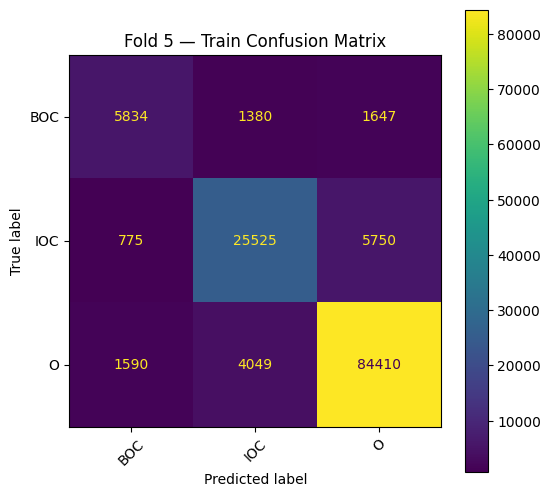

/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



Test classification report:
              precision    recall  f1-score   support

         BOC       0.56      0.52      0.54      1745
         IOC       0.70      0.67      0.68      6240
           O       0.87      0.89      0.88     17991

    accuracy                           0.81     25976
   macro avg       0.71      0.69      0.70     25976
weighted avg       0.81      0.81      0.81     25976



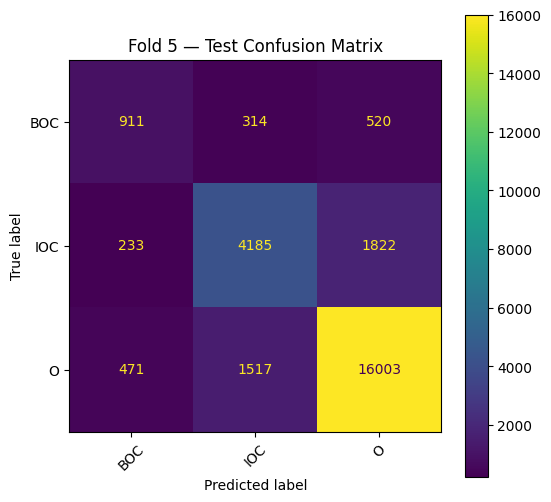

In [ ]:
# CELL 5 — FOLD 5
fold_idx = 5
train_idx, test_idx = splits[4]

train_data = hf_ds.select(train_idx)
test_data  = hf_ds.select(test_idx)

tokenized_train = train_data.map(tokenize_and_align_labels, batched=True, remove_columns=train_data.column_names)
tokenized_test  = test_data.map(tokenize_and_align_labels, batched=True, remove_columns=test_data.column_names)

model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_args = TrainingArguments(
    output_dir=f"./fold{fold_idx}",
    evaluation_strategy="epoch",
    save_strategy="no",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION,
    learning_rate=LEARNING_RATE,
    num_train_epochs=EPOCHS,
    weight_decay=WEIGHT_DECAY,
    warmup_steps=WARMUP_STEPS,
    fp16=FP16 and torch.cuda.is_available(),
    logging_strategy="epoch",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics
)

print(f"🚀 Training Fold {fold_idx} (epochs={EPOCHS}) ...")
trainer.train()

print(f"\n📊 Trainer Evaluate (Fold {fold_idx})")
eval_metrics = trainer.evaluate(eval_dataset=tokenized_test)
train_metrics = trainer.evaluate(eval_dataset=tokenized_train)

print("\n--- TRAIN METRICS (from trainer.evaluate) ---")
print(train_metrics)
print("\n--- TEST METRICS (from trainer.evaluate) ---")
print(eval_metrics)

# Confusion matrices
def preds_and_labels(tok_dataset):
    preds_output = trainer.predict(tok_dataset)
    preds = np.argmax(preds_output.predictions, axis=2)
    labels = preds_output.label_ids

    y_true = []
    y_pred = []
    for pred_seq, label_seq in zip(preds, labels):
        for p, l in zip(pred_seq, label_seq):
            if l != -100:
                y_true.append(id2label[int(l)])
                y_pred.append(id2label[int(p)])
    return y_true, y_pred

y_true_train, y_pred_train = preds_and_labels(tokenized_train)
cm_labels = label_list
print("\nTrain classification report:")
print(classification_report(y_true_train, y_pred_train, labels=cm_labels, zero_division=0))
fig = plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true_train, y_pred_train, labels=cm_labels), display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Train Confusion Matrix")
plt.show()

y_true_test, y_pred_test = preds_and_labels(tokenized_test)
print("\nTest classification report:")
print(classification_report(y_true_test, y_pred_test, labels=cm_labels, zero_division=0))
fig = plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true_test, y_pred_test, labels=cm_labels), display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Test Confusion Matrix")
plt.show()


Map:   0%|          | 0/10037 [00:00<?, ? examples/s]

Map:   0%|          | 0/2007 [00:00<?, ? examples/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipython-input-4161717756.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🚀 Training Fold 6 (epochs=5) ...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.682200,0.561840,0.252738,0.275681,0.263711,0.766181
2,0.526000,0.487805,0.339198,0.331581,0.335347,0.799202
3,0.453900,0.462535,0.380976,0.373149,0.377021,0.813697
4,0.396400,0.458858,0.397519,0.382704,0.389971,0.819200
5,0.353900,0.469194,0.393094,0.397038,0.395056,0.817495


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



📊 Trainer Evaluate (Fold 6)



--- TRAIN METRICS (from trainer.evaluate) ---
{'eval_loss': 0.2983129918575287, 'eval_precision': 0.4941266354693917, 'eval_recall': 0.4949775184157658, 'eval_f1': 0.49455171095392847, 'eval_accuracy': 0.8808318208855064, 'eval_runtime': 23.1352, 'eval_samples_per_second': 433.842, 'eval_steps_per_second': 27.145, 'epoch': 5.0}

--- TEST METRICS (from trainer.evaluate) ---
{'eval_loss': 0.46919429302215576, 'eval_precision': 0.3930936613055818, 'eval_recall': 0.3970377448638318, 'eval_f1': 0.3950558592821488, 'eval_accuracy': 0.8174947678474537, 'eval_runtime': 4.4141, 'eval_samples_per_second': 454.676, 'eval_steps_per_second': 28.545, 'epoch': 5.0}

Train classification report:
              precision    recall  f1-score   support

         BOC       0.71      0.65      0.68      8827
         IOC       0.82      0.79      0.80     31891
           O       0.92      0.93      0.93     90416

    accuracy                           0.88    131134
   macro avg       0.81      0.79     

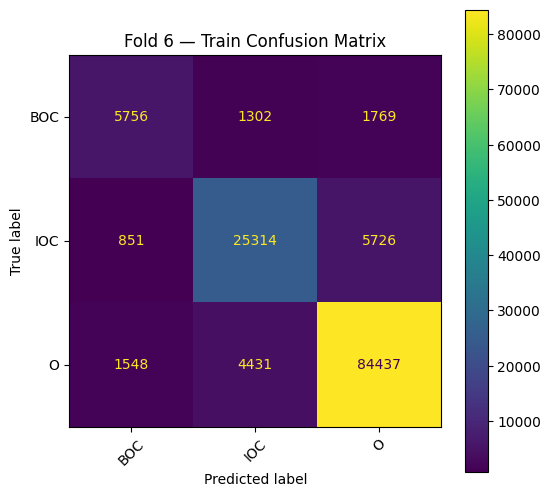

/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



Test classification report:
              precision    recall  f1-score   support

         BOC       0.60      0.53      0.56      1779
         IOC       0.72      0.68      0.70      6399
           O       0.87      0.90      0.88     17624

    accuracy                           0.82     25802
   macro avg       0.73      0.70      0.72     25802
weighted avg       0.81      0.82      0.82     25802



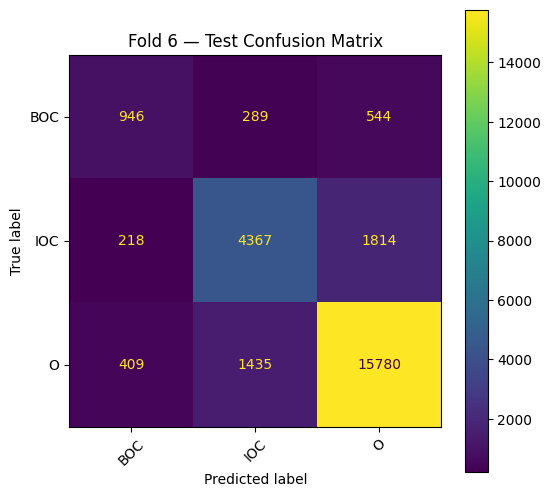

In [ ]:
# CELL 6 — FOLD 6
fold_idx = 6
train_idx, test_idx = splits[5]

train_data = hf_ds.select(train_idx)
test_data  = hf_ds.select(test_idx)

tokenized_train = train_data.map(tokenize_and_align_labels, batched=True, remove_columns=train_data.column_names)
tokenized_test  = test_data.map(tokenize_and_align_labels, batched=True, remove_columns=test_data.column_names)

model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_args = TrainingArguments(
    output_dir=f"./fold{fold_idx}",
    evaluation_strategy="epoch",
    save_strategy="no",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION,
    learning_rate=LEARNING_RATE,
    num_train_epochs=EPOCHS,
    weight_decay=WEIGHT_DECAY,
    warmup_steps=WARMUP_STEPS,
    fp16=FP16 and torch.cuda.is_available(),
    logging_strategy="epoch",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics
)

print(f"🚀 Training Fold {fold_idx} (epochs={EPOCHS}) ...")
trainer.train()

print(f"\n📊 Trainer Evaluate (Fold {fold_idx})")
eval_metrics = trainer.evaluate(eval_dataset=tokenized_test)
train_metrics = trainer.evaluate(eval_dataset=tokenized_train)

print("\n--- TRAIN METRICS (from trainer.evaluate) ---")
print(train_metrics)
print("\n--- TEST METRICS (from trainer.evaluate) ---")
print(eval_metrics)

# Confusion matrices
def preds_and_labels(tok_dataset):
    preds_output = trainer.predict(tok_dataset)
    preds = np.argmax(preds_output.predictions, axis=2)
    labels = preds_output.label_ids

    y_true = []
    y_pred = []
    for pred_seq, label_seq in zip(preds, labels):
        for p, l in zip(pred_seq, label_seq):
            if l != -100:
                y_true.append(id2label[int(l)])
                y_pred.append(id2label[int(p)])
    return y_true, y_pred

y_true_train, y_pred_train = preds_and_labels(tokenized_train)
cm_labels = label_list
print("\nTrain classification report:")
print(classification_report(y_true_train, y_pred_train, labels=cm_labels, zero_division=0))
fig = plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true_train, y_pred_train, labels=cm_labels), display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Train Confusion Matrix")
plt.show()

y_true_test, y_pred_test = preds_and_labels(tokenized_test)
print("\nTest classification report:")
print(classification_report(y_true_test, y_pred_test, labels=cm_labels, zero_division=0))
fig = plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true_test, y_pred_test, labels=cm_labels), display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Test Confusion Matrix")
plt.show()


Cleaned dataset size: 6415


Map:   0%|          | 0/5132 [00:00<?, ? examples/s]

Map:   0%|          | 0/1283 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1336151047.py:112: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🚀 Training sentiment classifier...


Epoch,Training Loss,Validation Loss,Accuracy,Weighted Precision,Weighted Recall,Weighted F1,Macro Precision,Macro Recall,Macro F1
1,0.116500,0.042205,0.989867,0.990073,0.989867,0.989923,0.978309,0.988956,0.983526
2,0.035900,0.026497,0.995323,0.995384,0.995323,0.995338,0.989273,0.995520,0.992361
3,0.019100,0.023739,0.996103,0.996182,0.996103,0.996118,0.989796,0.997603,0.993644
4,0.018400,0.018748,0.996103,0.996182,0.996103,0.996118,0.989796,0.997603,0.993644
5,0.008700,0.015974,0.996103,0.996182,0.996103,0.996118,0.989796,0.997603,0.993644



📊 Final Test Evaluation:


{'eval_loss': 0.015973832458257675, 'eval_accuracy': 0.9961028838659393, 'eval_weighted_precision': 0.9961824168482669, 'eval_weighted_recall': 0.9961028838659393, 'eval_weighted_f1': 0.9961182903104766, 'eval_macro_precision': 0.9897959183673469, 'eval_macro_recall': 0.9976030680728667, 'eval_macro_f1': 0.9936440153177745, 'eval_runtime': 7.992, 'eval_samples_per_second': 160.536, 'eval_steps_per_second': 10.135, 'epoch': 5.0}

🔍 Generating Confusion Matrix...

Confusion Matrix (Numbers):
[[ 240    0]
 [   5 1038]]


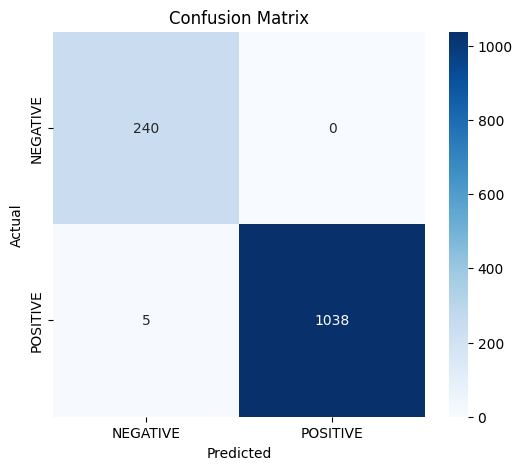

In [ ]:
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------
# LOAD DATA
# -----------------------
df = pd.read_csv("/content/TV_Reviews_Cause_Sentiment(TV_Reviews_Cause_Sentiment).csv", encoding="latin1")

df = df[["Causal Phrase", "Sentiment"]].copy()
df["Sentiment"] = df["Sentiment"].astype(str).str.strip()
df = df[df["Sentiment"] != ""]

label2id = {"NEGATIVE": 0, "POSITIVE": 1}
id2label = {0: "NEGATIVE", 1: "POSITIVE"}

df = df[df["Sentiment"].isin(label2id.keys())]
df["label"] = df["Sentiment"].map(label2id)
df = df.dropna()

print("Cleaned dataset size:", len(df))

# -----------------------
# TRAIN / TEST SPLIT
# -----------------------
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

train_ds = Dataset.from_pandas(train_df[["Causal Phrase", "label"]])
test_ds  = Dataset.from_pandas(test_df[["Causal Phrase", "label"]])

# -----------------------
# TOKENIZER
# -----------------------
MODEL_NAME = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(batch["Causal Phrase"], truncation=True, padding="max_length", max_length=128)

train_ds = train_ds.map(tokenize, batched=True)
test_ds  = test_ds.map(tokenize, batched=True)

train_ds = train_ds.rename_column("label", "labels")
test_ds  = test_ds.rename_column("label", "labels")

train_ds.set_format("torch", columns=["input_ids","attention_mask","labels"])
test_ds.set_format("torch", columns=["input_ids","attention_mask","labels"])

# -----------------------
# MODEL
# -----------------------
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

# -----------------------
# METRICS
# -----------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    acc = accuracy_score(labels, preds)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    pm, rm, f1m, _ = precision_recall_fscore_support(labels, preds, average="macro")

    return {
        "accuracy": acc,
        "weighted_precision": p,
        "weighted_recall": r,
        "weighted_f1": f1,
        "macro_precision": pm,
        "macro_recall": rm,
        "macro_f1": f1m
    }

# -----------------------
# TRAINER
# -----------------------
training_args = TrainingArguments(
    output_dir="./sentiment_roberta",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_strategy="epoch",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics
)

# -----------------------
# TRAIN
# -----------------------
print("🚀 Training sentiment classifier...")
trainer.train()

# -----------------------
# FINAL EVALUATION
# -----------------------
print("\n📊 Final Test Evaluation:")
metrics = trainer.evaluate(test_ds)
print(metrics)

# -----------------------
# CONFUSION MATRIX
# -----------------------
print("\n🔍 Generating Confusion Matrix...")

# Get raw predictions
pred_output = trainer.predict(test_ds)
preds = np.argmax(pred_output.predictions, axis=1)
true_labels = pred_output.label_ids

# Compute confusion matrix
cm = confusion_matrix(true_labels, preds)

print("\nConfusion Matrix (Numbers):")
print(cm)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["NEGATIVE", "POSITIVE"],
            yticklabels=["NEGATIVE", "POSITIVE"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
